# Fire Hazard Incidents Analytics Pipeline
## Firefighter Severity vs Average Losses in dollars

## Importing Required Libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

from storedb import save_in_db, IMG_PATH

## Creating Spark Session and using all available cores

In [4]:
%%time
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

22/12/11 20:33:16 WARN Utils: Your hostname, Janhvis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.109 instead (on interface en0)
22/12/11 20:33:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 20:33:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/11 20:33:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
CPU times: user 20.8 ms, sys: 21.1 ms, total: 41.9 ms
Wall time: 2.41 s


## Loading firefighter casuality and basic module data

In [5]:
%%time
firefighter_casualities_df = spark.read.options(delimiter="^", header=True).csv("ffcasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")

CPU times: user 3.81 ms, sys: 2.72 ms, total: 6.52 ms
Wall time: 2.9 s


In [6]:
%%time
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))
total_loss = basic_module_df.groupBy("INCIDENT_KEY").agg(F.sum(basic_module_df.PROP_LOSS + basic_module_df.CONT_LOSS).alias("TOTAL_LOSS"))

CPU times: user 4.42 ms, sys: 2.89 ms, total: 7.31 ms
Wall time: 113 ms


In [7]:
%%time
# Finding Firefighter Injury Severity vs. Dollar Loss
firefighter_dollar_loss = total_loss.join(firefighter_casualities_df, total_loss.INCIDENT_KEY == firefighter_casualities_df.INCIDENT_KEY)
ffdl_df = firefighter_dollar_loss.groupBy("SEVERITY").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))
p_ffdl_df = ffdl_df.toPandas()

CPU times: user 209 ms, sys: 58.3 ms, total: 267 ms
Wall time: 5.3 s


CPU times: user 75.2 ms, sys: 8.23 ms, total: 83.5 ms
Wall time: 82.7 ms


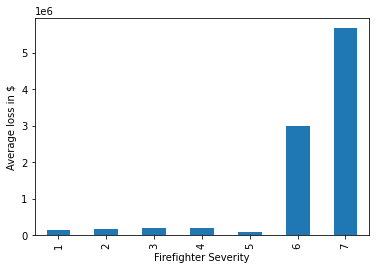

In [9]:
%%time
p2 = p_ffdl_df.drop([3]).sort_values(by="SEVERITY").plot(x="SEVERITY", y="AVG_LOSS", xlabel="Firefighter Severity", ylabel = "Average loss in $", kind="bar", legend = False)
fig2 = p2.get_figure()
fig_name = "ff_dollar_loss.png"
fig2.savefig(f"{IMG_PATH}{fig_name}")

# saving to db
save_in_db(fig_name, "firefighter_severity_vs_dollar_losses")
